<a href="https://colab.research.google.com/github/eddercipras/Tesis/blob/main/DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.9.2
!pip install q keras==2.9.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import datetime, os
import yaml

In [ ]:
#for check version tensorflow and GPU avalaible
print(tf. __version__)
tf.test.gpu_device_name()
#!nvidia-smi

2.9.2


'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/project/parameters.yaml") as conf_file:
  config = yaml.full_load(conf_file)

In [ ]:
categories = os.listdir(config["data"]["raw_images"])
n_categorias = len(categories)
print(f"Tenemos {n_categorias} categorías:\n{[category for category in categories]}")

Tenemos 4 categorías:
['Healthy', 'Blight', 'Common_Rust', 'Armyworm']


In [ ]:
image_size = config["preprocesamiento"]["image_size"]
batch_size = config["preprocesamiento"]["batch_size"]
validation_split = config["preprocesamiento"]["validation_split"]
seed = config["global"]["seed"]

# Node training_set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    config["data"]["raw_images"],
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
# Node validation_set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    config["data"]["raw_images"],
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)



Found 5158 files belonging to 4 classes.
Using 4127 files for training.
Found 5158 files belonging to 4 classes.
Using 1031 files for validation.


In [ ]:
for idx, category in enumerate(categories):
    print("Índice:", idx)
    print("Categoría:", category)


Índice: 0
Categoría: Healthy
Índice: 1
Categoría: Blight
Índice: 2
Categoría: Common_Rust
Índice: 3
Categoría: Armyworm


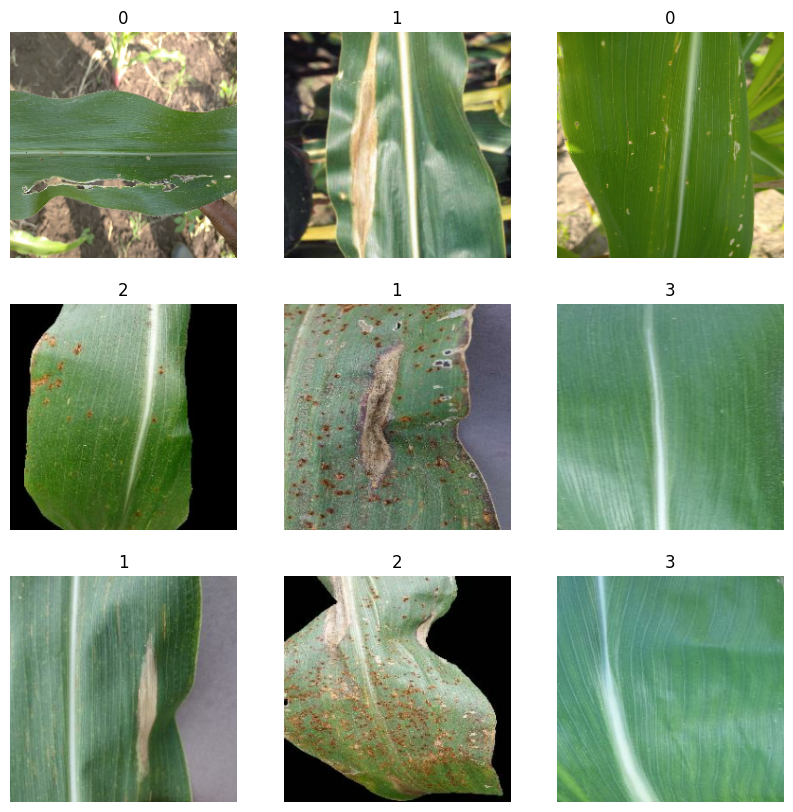

In [ ]:
# node muestreo_imagenes
import matplotlib.pyplot as plt

plt.figure(figsize=config["utils"]["muestreo_imagenes"]["image_size"])
for images, labels in train_ds.take(1):
    for i in range(config["utils"]["muestreo_imagenes"]["num_imagenes"]):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# node augmentation
data_augmentation = keras.Sequential(
    [
        # # Rotación de imágenes horizontal y vertical
        layers.RandomFlip(mode=config["augmentation"]["random_flip"]["mode"]),
        # Rotación
        layers.RandomRotation(fill_mode=config["augmentation"]["RandomRotation"]["fill_mode"],
        interpolation=config["augmentation"]["RandomRotation"]["interpolation"],
        factor=config["augmentation"]["RandomRotation"]["factor"]),
        layers.RandomZoom(height_factor=config["augmentation"]["RandomZoom"]["height_factor"],
        width_factor=config["augmentation"]["RandomZoom"]["width_factor"]),
    ]
)

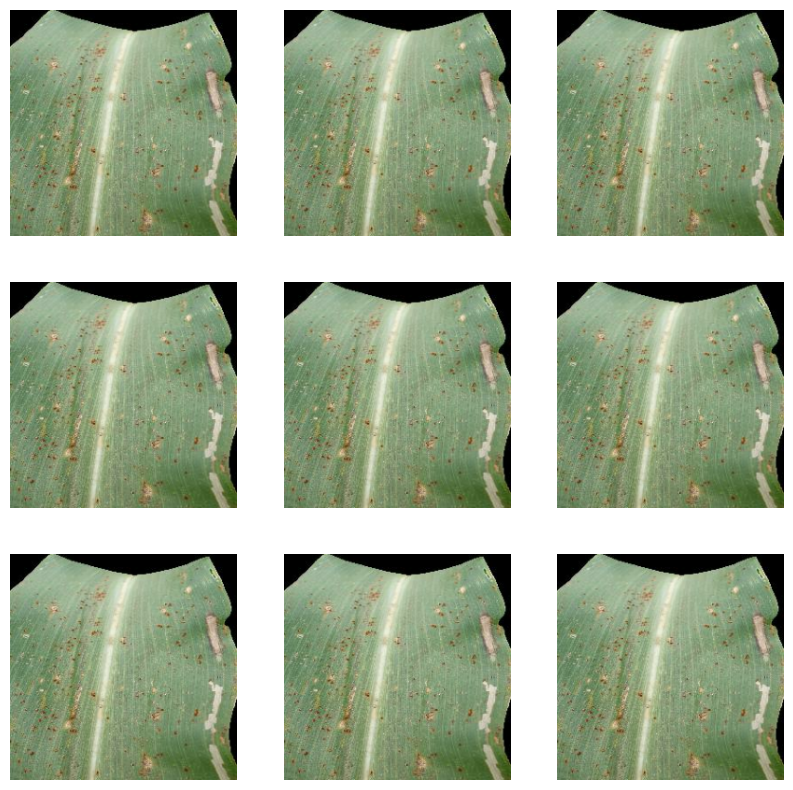

In [ ]:
# node
plt.figure(figsize=config["utils"]["muestreo_imagenes"]["image_size"])
for images, _ in train_ds.take(1):
    for i in range(config["utils"]["muestreo_imagenes"]["num_imagenes"]):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
buffer_size = config["preprocesamiento"]["buffer_size"]

# node
train_ds = train_ds.prefetch(buffer_size=buffer_size)
# node
val_ds = val_ds.prefetch(buffer_size=buffer_size)

74836368/74836368 [==============================] - 4s 0us/step


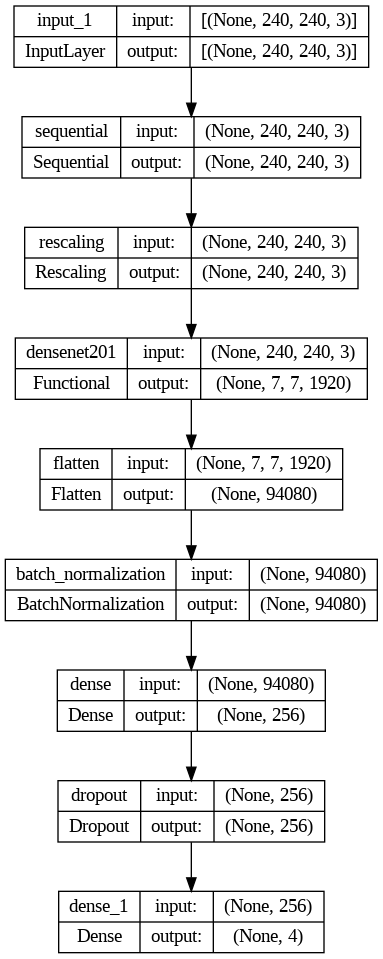

In [ ]:
# node
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)

    # Pretrained model
    base_model = keras.applications.DenseNet201(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape)

    #

    outputs = base_model(x)
    outputs = layers.Flatten()(outputs)
    outputs = layers.BatchNormalization(axis=-1,
                                        momentum=config["model"]["batch_normalization"]["momentum"],
                                        epsilon=config["model"]["batch_normalization"]["epsilon"])(outputs)
    outputs = layers.Dense(config["model"]["dense_1"]["units"],
                           kernel_regularizer = regularizers.l2(l = config["model"]["dense_1"]["l2"]),
                           activity_regularizer = regularizers.l1(config["model"]["dense_1"]["l1"]),
                           bias_regularizer = regularizers.l1(config["model"]["dense_1"]["bias_regularizer"]),
                           activation = config["model"]["dense_1"]["activation"])(outputs)
    outputs = layers.Dropout(rate = config["model"]["dropout"]["rate"], seed = config["global"]["seed"])(outputs)
    outputs = layers.Dense(n_categorias, activation=config["model"]["dense_2"]["activation"])(outputs)

    return keras.Model(inputs, outputs)

# node
model = make_model(input_shape=image_size + (3,), num_classes = n_categorias)
# logging
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

log_dir = config["logs"]["path"] + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=config["callbacks"]["early_stopping"]["patience"]),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=config["callbacks"]["reducelronplateau"]["monitor"],
                                         factor=config["callbacks"]["reducelronplateau"]["factor"],
                                         patience=config["callbacks"]["reducelronplateau"]["patience"],
                                         min_lr=config["callbacks"]["reducelronplateau"]["min_lr"]),
    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(config["save_model"]["path"],
                                                             "DenseNet201.{epoch:02d}-{val_accuracy:.2f}.h5"),
                                       monitor="val_accuracy",
                                       mode="max",
                                       save_best_only=True),]

model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=config["compile"]["lr"]),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
history = model.fit(train_ds, epochs=epochs,
          callbacks=[my_callbacks], validation_data=val_ds,)

Epoch 1/50
129/129 [==============================] - 135s 863ms/step - loss: 6.5300 - accuracy: 0.9050 - val_loss: 4.8348 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 2/50
129/129 [==============================] - 109s 841ms/step - loss: 3.6964 - accuracy: 0.9666 - val_loss: 3.5211 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 3/50
129/129 [==============================] - 98s 754ms/step - loss: 2.6459 - accuracy: 0.9794 - val_loss: 3.9976 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 4/50
129/129 [==============================] - 105s 803ms/step - loss: 1.9151 - accuracy: 0.9804 - val_loss: 1.8614 - val_accuracy: 0.9651 - lr: 0.0010
Epoch 5/50
129/129 [==============================] - 105s 805ms/step - loss: 1.4139 - accuracy: 0.9847 - val_loss: 1.1667 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 6/50
129/129 [==============================] - 98s 753ms/step - loss: 1.0449 - accuracy: 0.9872 - val_loss: 1.0643 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/50
129/129 [============================

In [ ]:
import pickle
import datetime
log_file_path = "/content/drive/MyDrive/project/logs/DenseNet201-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
with open(log_file_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Populating the interactive namespace from numpy and matplotlib


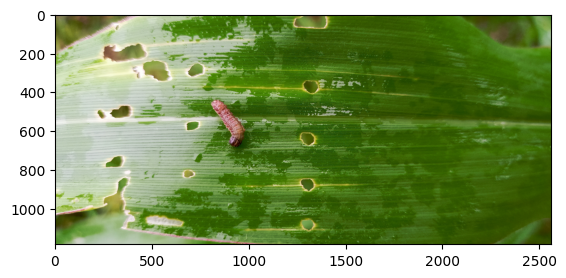

1/1 [==============================] - 0s 163ms/step
This image is:
 0.99 Armyworm
 0.00 percent Blight
 0.00 percent Common_Rust
 0.00 Healthy


In [ ]:
%pylab inline
img_path = "/content/drive/MyDrive/project/data/unzipped/data/Armyworm/20230310_114951.JPG"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show();
img = keras.preprocessing.image.load_img(img_path, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    f"This image is:\n {score[0]:.2f} Armyworm\n {score[1]:.2f} percent Blight\n {score[2]:.2f} percent Common_Rust\n {score[3]:.2f} Healthy")


## Matriz de Confusión

In [ ]:
%pip install mlxtend --upgrade

In [ ]:
#testing_dir = "/content/drive/MyDrive/project/data/test/data_test/"
from mlxtend.plotting import plot_confusion_matrix
import mlxtend
print(mlxtend.__version__)

0.22.0


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score,classification_report
from sklearn import metrics

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
names = ['Armyworm','Blight','Common_Rust','Healthy']

In [ ]:
#ImageDataGenerator() para leer los datos de test
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    config["data_test"]["test_images"],
    target_size=(240,240),
    batch_size=batch_size,
    class_mode='categorical',
#se configura en false para garantizar que las predicciones
#se ordenen y coincidan con las etiquetas
    shuffle=False
)

Found 320 images belonging to 4 classes.


In [ ]:
#custom_Model= load_model("DenseNet201.10-0.99.h5")
custom_Model = load_model("/content/drive/MyDrive/project/models/DenseNet201.10-0.99.h5")

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

<ipython-input-14-8a9ec564546b>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator)


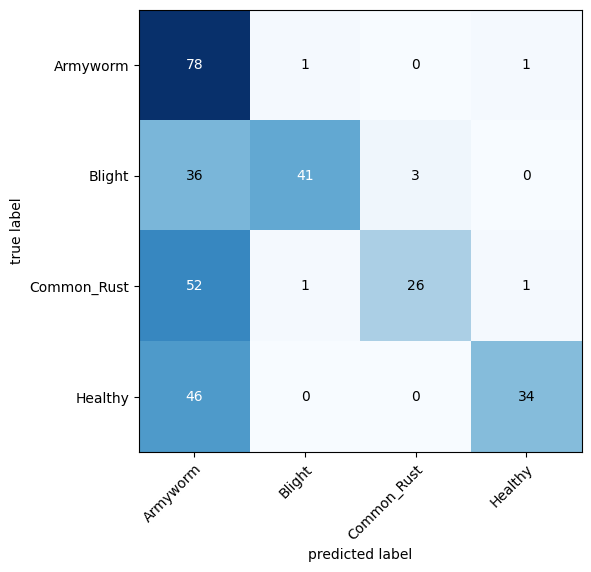

In [ ]:
cm=metrics.confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=cm, figsize=(6,6), class_names = names, show_normed=False)
plt.tight_layout()



In [ ]:
test_generator.class_indices

print('Reporte de Métricas')
print(classification_report(test_generator.classes, y_pred, target_names=names))

Reporte de Métricas
              precision    recall  f1-score   support

    Armyworm       0.37      0.97      0.53        80
      Blight       0.95      0.51      0.67        80
 Common_Rust       0.90      0.33      0.48        80
     Healthy       0.94      0.42      0.59        80

    accuracy                           0.56       320
   macro avg       0.79      0.56      0.57       320
weighted avg       0.79      0.56      0.57       320

